# Import Statements

In [1]:
import numpy as np
import math
import cmath
from random import randint
from matplotlib import pyplot as plt
import scipy
from scipy import signal

# Data Setup for Geo Sim

In [2]:
# File from Luke
samples = np.fromfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\Rand16Q_255", np.complex64) # Read in file.  We have to tell it what format it is

test = np.array(samples)
print(test.shape)

(1000000,)


In [3]:
# Setup for the geometry simulator

# Calculate speed of light to be used in calculating time delay
eps0 = 8.854187817e-12
mu0 = 4*np.pi * 1e-7
c0 = 1/np.sqrt(eps0*mu0)

# Frequencies to be used
fs = 20000000  # sampling frequency
fs1 = 2.45e9  # transmitting frequency
lambda1 = c0/fs1  # Wavelength of transmitting frequency

# Generate RX geometry location
RX = np.zeros(2) 
RX[1] = 0  # Middle RX element y-location
RX[0] = RX[1] + lambda1/2  # Location of top RX element

# Antenna Geometry
horz_elements = 2 # horizontal antenna elements (rows)
vert_elements = 1 # vertical antenna elements (col)
num_elements = horz_elements * vert_elements # number of antenna elements

# creating blank arrays to store the values from the geometry simulator
elements = [[], []] # empty matrix to store each elements data
angleofArrival = [] # empty matrix to store DoA
print(elements) # examples of indexing elements[0][0] = 1, elements[1][2] = 3 

[[], []]


In [4]:
# Reducing the amount of samples from the file from Luke
N = 1024 # size of the sample, fft size, 512 and 1000 seemed to give good values

small_samples = np.zeros(N, complex) # blank array to store the data

# Create smaller signal to work with
for i in range(N):
    small_samples[i] = samples[i]

# print(small_samples.shape)

# Geo Sim

In [5]:
# Generating the Data for the NN
numberofSamples = 10

for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(2)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(2) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(2) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    # converting the signal into the frequency domain
    fsmall_samples = np.fft.fft(small_samples)
    fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    shift0 = fsmall_samples*np.exp(-1j*2*np.pi*fs1*totaltd[0])
    shift1 = fsmall_samples*np.exp(-1j*2*np.pi*fs1*totaltd[1])

    shift0 = np.fft.ifftshift(shift0)
    shift1 = np.fft.ifftshift(shift1)

    # converting from frequency domain back to time domain
    shift0 = np.fft.ifft(shift0)
    shift1 = np.fft.ifft(shift1)
    
    # storing the data
    elements[0].append(shift0) # storing the data for element 1
    elements[1].append(shift1) # storing the data for element 2 
    angleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[2.31036318e-11 0.00000000e+00]
[-6.50558812 -6.49494027]


# Verifying Geo Sim Output

In [6]:
# checking the shape and values for element 1
element1 = np.array(elements[0]) 
print(element1.shape)

# checking the shape and values for elements
testEle1 = np.array(elements)
print(testEle1.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(10, 1024)
(2, 10, 1024)


In [7]:
# checking the shape and values for element 1
element1 = np.array(elements[1])
print(element1.shape)

# checking the shape and values for elements
testEle2 = np.array(elements)
print(testEle2.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(10, 1024)
(2, 10, 1024)


In [8]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)

# for i in angleofArrival:
#     print(i)

(10,)


# Cross Correlation

In [9]:
# Data setup for the correlation and averaging
element1 = np.array(elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
element2 = np.array(elements[1])

test = np.array(element1[0])
print(element1.shape)
print(test.shape)

(10, 1024)
(1024,)


In [10]:
# corr each time step then take the mean
corr = []  # creating a blank array to store the correlations in

corr = signal.correlate(element1, element2, mode='same', method='auto')

test = np.array(corr)
print(test.shape)

(10, 1024)


# Correlation Output

C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-11-cd9fd614df12>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


-1.474005350784887


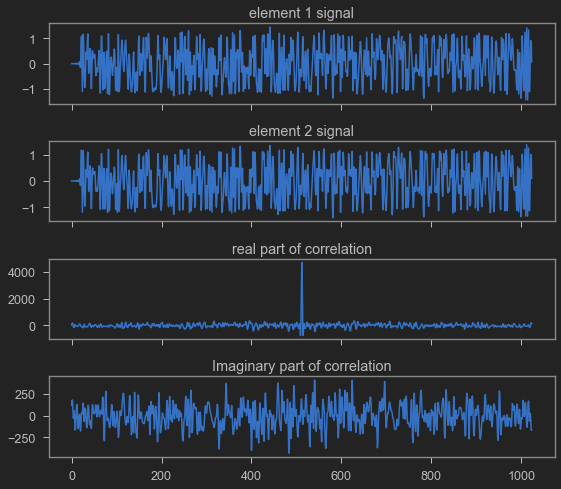

In [11]:
# Plotting the real part of the correlation
corrREAL = np.real(np.array(corr)) # 1&2
corrIMAG = np.imag(np.array(corr)) # 1&2

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_signal1, ax_signal2, ax_corrREAL, ax_corrIMAG) = plt.subplots(4, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 0

# Element 1
ax_signal1.plot(element1[sample])
ax_signal1.set_title('element 1 signal')

# Element 2
ax_signal2.plot(element2[sample])
ax_signal2.set_title('element 2 signal')

# cross correlation between element 1 and 2, real part
ax_corrREAL.plot(corrREAL[sample])
ax_corrREAL.set_title('real part of correlation')

# cross correlation between element 1 and 2, imag part
ax_corrIMAG.plot(corrIMAG[sample])
ax_corrIMAG.set_title('Imaginary part of correlation')

fig.tight_layout()
fig.show()

print(angleofArrival[sample])

C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-12-80a4c40a8240>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


-6.50558811952527


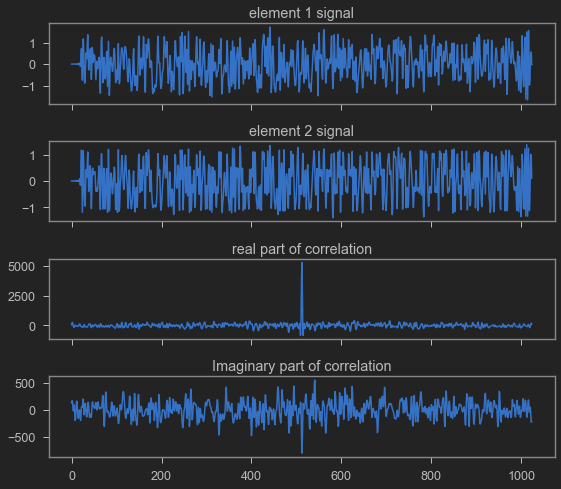

In [12]:
# Plotting the real part of the correlation
corrREAL = np.real(np.array(corr)) # 1&2
corrIMAG = np.imag(np.array(corr)) # 1&2

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_signal1, ax_signal2, ax_corrREAL, ax_corrIMAG) = plt.subplots(4, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 9

# Element 1
ax_signal1.plot(element1[sample])
ax_signal1.set_title('element 1 signal')

# Element 2
ax_signal2.plot(element2[sample])
ax_signal2.set_title('element 2 signal')

# cross correlation between element 1 and 2, real part
ax_corrREAL.plot(corrREAL[sample])
ax_corrREAL.set_title('real part of correlation')

# cross correlation between element 1 and 2, imag part
ax_corrIMAG.plot(corrIMAG[sample])
ax_corrIMAG.set_title('Imaginary part of correlation')

fig.tight_layout()
fig.show()

print(angleofArrival[sample])

In [13]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)

for i in angleofArrival:
    print(i)

(10,)
-1.474005350784887
1.1046332427267842
10.768169401041279
-3.801091460657642
7.2829958582032255
-6.062945499952347
-11.329192046964776
-11.881395182371875
8.231192342816803
-6.50558811952527


# Complex to polar

In [14]:
# Concatinating the real and imag parts of the correlation
realCorr = np.real(np.array(corr))
imagCorr = np.imag(np.array(corr))

# combing the real and imaginary values [real,imag]
complexCorr = np.concatenate((realCorr,imagCorr),axis=-1)
print(complexCorr.shape)

(10, 2048)


In [15]:
# Converting to polar from complex
tempCorr = np.array(corr)
print(tempCorr.shape)

polarCorr = np.concatenate((tempCorr, np.zeros((numberofSamples, N))), axis=-1)
print(polarCorr.shape)

for j in range(numberofSamples):
    for i in range(N):
        temp = abs(tempCorr[j][i])
        temp2 = cmath.phase(tempCorr[j][i])
        polarCorr[j][i] = float(temp)
        polarCorr[j][N+i] = temp2

print('--------------------')
print(polarCorr.shape)
print(polarCorr[0].shape)

(10, 1024)
(10, 2048)
--------------------
(10, 2048)
(2048,)


In [16]:
for i in range(10):
    print(np.real(polarCorr[0][i]))

122.08448968572351
227.88234116465932
261.6127367008051
115.9869788885752
65.15437867999434
157.62735664412025
144.88898035630046
51.573651224403505
177.2728206681501
139.81875964495282


In [17]:
for i in range(256,266):
    print(np.real(polarCorr[0][i]))

124.88070912536458
197.16636194983795
241.63429411395666
201.0072281916473
153.9169515054894
97.89634639812867
292.5221411444684
169.55480767993566
278.06292324814814
383.3262584067935


In [18]:
for i in range(10):
    print(np.real(polarCorr[1][i]))

141.98308219495323
265.01166769540004
304.23480775518306
134.88529795819923
75.77446448539477
183.31426035453202
168.4926977184652
59.95982869435117
206.15243949599736
162.60055005389728


In [19]:
for i in range(256,266):
    print(np.real(polarCorr[1][i]))

145.20452971715667
229.26852579666073
280.980107564312
233.73160176624927
178.98337210669126
113.84260129744543
340.1829355235021
197.20604899997912
323.384228848169
445.7885504469842


In [20]:
for i in angleofArrival:
    print(i)

-1.474005350784887
1.1046332427267842
10.768169401041279
-3.801091460657642
7.2829958582032255
-6.062945499952347
-11.329192046964776
-11.881395182371875
8.231192342816803
-6.50558811952527


# BLANK